<a id='index'></a>
# Index
* <a href='#introduction'>Introduction</a>
* <a href='#preprocessing'>Preprocessing</a>

<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

TODO

In [213]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import warnings

<a href='#index'>...</a>
<a id='preprocessing'></a>
# Preprocessing

### Preprocessing function definition

In [3]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None)

In [4]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [211]:
def custom_plot(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None):
    col = 0
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    for i in range(dim_x):
        for j in range(dim_y):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
            kde_x, kde_y = ax.lines[0].get_data()
            ax.fill_between(kde_x, kde_y, where=(kde_x<20), interpolate=True, color='#EF9A9A')
            axes[i,j].set_title(titles[col])  
            col+=1

### Data loading <a id='second-bullet'></a>

In [142]:
root_folder = '../CDSL_HM_20200720_RAW'

In [150]:
# CDSL_01
df_patient = pd.read_csv(root_folder+'/CDSL_01.csv', sep=';')
# CDSL_02
df_med = pd.read_csv(root_folder+'/CDSL_02.csv', sep=';')#, encoding='iso-8859-1')
# CDSL_03
df_vital = pd.read_csv(root_folder+'/CDSL_03.csv', sep=';')
# CDSL_05 (emergency)
df_ICD10_emer = pd.read_csv(root_folder+'/CDSL_05.csv', sep=';')
# CDSL_06  (admission)
df_ICD10_adm = pd.read_csv(root_folder+'/CDSL_06.csv', sep=';')

In [144]:
# CDSL_04
df_lab = pd.read_csv(root_folder+'/CDSL_04.csv', sep=';', error_bad_lines=False, encoding='iso-8859-1')

b'Skipping line 28039: expected 8 fields, saw 12\nSkipping line 32182: expected 8 fields, saw 12\nSkipping line 44299: expected 8 fields, saw 12\n'
b'Skipping line 90790: expected 8 fields, saw 12\nSkipping line 105234: expected 8 fields, saw 12\nSkipping line 130735: expected 8 fields, saw 10\n'
b'Skipping line 136659: expected 8 fields, saw 10\nSkipping line 140398: expected 8 fields, saw 10\nSkipping line 141687: expected 8 fields, saw 12\nSkipping line 142745: expected 8 fields, saw 12\nSkipping line 170183: expected 8 fields, saw 12\n'
b'Skipping line 223336: expected 8 fields, saw 21\nSkipping line 237392: expected 8 fields, saw 12\n'
b'Skipping line 373889: expected 8 fields, saw 12\nSkipping line 382978: expected 8 fields, saw 10\n'
b'Skipping line 412136: expected 8 fields, saw 12\nSkipping line 419764: expected 8 fields, saw 12\nSkipping line 421226: expected 8 fields, saw 12\nSkipping line 426429: expected 8 fields, saw 11\nSkipping line 444865: expected 8 fields, saw 12\n'


In [151]:
df_patient = df_patient.rename(columns=
                        {"PATIENT ID":"PATIENT_ID", "EDAD/AGE":"AGE", "SEXO/SEX":"SEX", "DIAG ING/INPAT":"DIAG_INPAT", 
                        "F_INGRESO/ADMISSION_D_ING/INPAT":"ADMISSION_DATE_INPAT","HORA/TIME_ADMISION/ADMISSION_URG/EMERG":
                         "TIME_ADMISSION_EMERG","F_ENTRADA_UC/ICU_DATE_IN":"ICU_DATE_IN", 
                        "F_SALIDA_UCI/ICU_DATE_OUT":"ICU_DATE_OUT","UCI_DIAS/ICU_DAYS": "ICU_DAYS", 
                        "RESPIRADOR/MECH.VENT.":"MECH.VENT.", "F_ALTA/DISCHARGE_DATE_ING":"DISCHARGE_DATE_ING", 
                        "MOTIVO_ALTA/DESTINY_DISCHARGE_ING":"DESTINY_DISCHARGE_ING","F_INGRESO/ADMISSION_DATE_URG/EMERG":
                        "ADMISSION_DATE_EMERG", "HORA/TIME_ADMISION/ADMISSION_EMERG/EMERG":"TIME_ADMISION_EMERG", 
                        "ESPECIALIDAD/DEPARTMENT_URG/EMERG":"DEPARTMENT_EMERG","DIAG_URG/EMERG":"DIAG_EMERG", 
                        "DESTINO/DESTINY_URG/EMERG":"DESTINY_EMERG", "HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG" : 
                        "TIME_CONSTANT_FIRST_EMERG", "TEMP_PRIMERA/FIRST_URG/EMERG":"TEMP_FIRST_EMERG", "FC/HR_PRIMERA/FIRST_URG/EMERG": 
                        "HR_FIRST_EMERG", "GLU_PRIMERA/FIRST_URG/EMERG":"GLU_FIRST_EMERG", "SAT_02_PRIMERA/FIRST_URG/EMERG":
                        "SAT_02_FIRST_EMERG", "TA_MAX_PRIMERA/FIRST/EMERG_URG":"TA_MAX_FIRST_EMERG", "TA_MIN_PRIMERA/FIRST_URG/EMERG":
                        "TA_MIN_FIRST_EMERG", "HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG":"TIME_CONSTANT_LAST_EMERG", 
                        "FC/HR_ULTIMA/LAST_URG/EMERG":"HR_LAST_EMERG", "TEMP_ULTIMA/LAST_URG/EMERG":"TEMP_LAST_EMERG", 
                        "GLU_ULTIMA/LAST_URG/EMERG":"GLU_LAST_EMERG", "SAT_02_ULTIMA/LAST_URG/EMERG":"SAT_02_LAST_EMERG", 
                        "TA_MAX_ULTIMA/LAST_URGEMERG":"TA_MAX_LAST_EMERG", "TA_MIN_ULTIMA/LAST_URG/EMERG":"TA_MIN_LAST_EMERG"})

custom_columns = ['PATIENT_ID', 'AGE', 'SEX', 
                  'DIAG_INPAT', 'ADMISSION_DATE_INPAT',
                  'ADMISSION_DATE_EMERG','DISCHARGE_DATE_ING','TIME_ADMISSION_EMERG', 
                  'DEPARTMENT_EMERG', 'DIAG_EMERG','DESTINY_EMERG',
                  'ICU_DATE_IN', 'ICU_DATE_OUT','ICU_DAYS', 
                  'MECH.VENT.', 'TIME_CONSTANT_FIRST_EMERG', 'TIME_CONSTANT_LAST_EMERG', 
                  'HR_FIRST_EMERG','HR_LAST_EMERG',
                  'SAT_02_FIRST_EMERG', 'SAT_02_LAST_EMERG',
                  'TA_MAX_FIRST_EMERG','TA_MAX_LAST_EMERG',
                  'TA_MIN_FIRST_EMERG','TA_MIN_LAST_EMERG', 
                  'TEMP_FIRST_EMERG','TEMP_LAST_EMERG',
                  'GLU_FIRST_EMERG','GLU_LAST_EMERG',
                  'DESTINY_DISCHARGE_ING']

df_patient = df_patient.reindex(columns=custom_columns)

In [152]:
# EXPERIMENTACION
# TODAS LAS FILAS QUE CONTIENEN ALGO DE ICU TIENEN LAS 3 COLUMNAS COMPLETAS
len(df_patient[(~df_patient['ICU_DATE_IN'].isnull())&(~df_patient['ICU_DATE_OUT'].isnull())&(~df_patient['ICU_DAYS'].isnull())])

228

In [153]:
print("MALE/FEMALE %: {:.2f}%".format(column_percentage(df_patient,'SEX','MALE')))
print("CONFIRMED COVID/SUSPECTED COVID %: {:.2f}%".format(column_percentage(df_patient,'DIAG_INPAT','COVID CONFIRMADO')))
print("DECEASED/OTHERWISE %: {:.2f}%".format(column_percentage(df_patient,'DESTINY_DISCHARGE_ING','Fallecimiento')))
print("Inpatients without being in ER: {}. Inpatients being in ER: {}".format(\
      df_patient.shape[0] - len(df_patient[~df_patient['ADMISSION_DATE_EMERG'].isnull()]), \
      len(df_patient[~df_patient['ADMISSION_DATE_EMERG'].isnull()])))

MALE/FEMALE %: 0.59%
CONFIRMED COVID/SUSPECTED COVID %: 0.91%
DECEASED/OTHERWISE %: 0.15%
Inpatients without being in ER: 90. Inpatients being in ER: 2457


In [154]:
# Create ICU feature
df_patient['ICU']=0
df_patient.loc[~df_patient['ICU_DAYS'].isnull(),['ICU']]=1
# Create ER feature
df_patient['ER']=0
df_patient.loc[~df_patient['ADMISSION_DATE_EMERG'].isnull(),['ER']]=1

In [156]:
# REMOVE COLUMNS OF DATES (WHY USE THEM?): 'ICU_DATE_IN','ICU_DATE_OUT','ICU_DAYS','TIME_ADMISSION_EMERG',
                                          # 'DISCHARGE_DATE_ING', 'TIME_CONSTANT_FIRST_EMERG'
# REMOVE ADMISSION DATES TOO...           # 'ADMISSION_DATE_INPAT', 'ADMISSION_DATE_EMERG'  

# REMOVE LAST CHECK COLUMNS (?): 'TIME_CONSTANT_LAST_EMERG', 'HR_LAST_EMERG', 'SAT_02_LAST_EMERG', 
                                # TA_MIN_LAST_EMERG', 'TA_MAX_LAST_EMERG',
                                # 'TEMP_LAST_EMERG', 'GLU_LAST_EMERG'
        
# REMOVE 'DESTINY_EMERG', all samples are "ingresado"

df_patient = df_patient.drop(columns=['ICU_DATE_IN','ICU_DATE_OUT','ICU_DAYS','TIME_ADMISSION_EMERG',
                                      'DISCHARGE_DATE_ING','TIME_CONSTANT_LAST_EMERG', 'HR_LAST_EMERG',
                                      'SAT_02_LAST_EMERG', 'TA_MIN_LAST_EMERG', 'TA_MAX_LAST_EMERG',
                                      'TEMP_LAST_EMERG', 'GLU_LAST_EMERG','DESTINY_EMERG','TIME_CONSTANT_FIRST_EMERG',
                                      'ADMISSION_DATE_INPAT','ADMISSION_DATE_EMERG'])


In [35]:
len(set(df_vital['IDINGRESO'].unique()).intersection(set(df_med['IDINGRESO'].unique())))

2511

In [157]:
# df_patient = df_patient.drop(columns=['ADMISSION_DATE_INPAT','ADMISSION_DATE_EMERG'])
df_patient.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PATIENT_ID             2547 non-null   int64  
 1   AGE                    2547 non-null   int64  
 2   SEX                    2547 non-null   object 
 3   DIAG_INPAT             2547 non-null   object 
 4   DEPARTMENT_EMERG       2457 non-null   object 
 5   DIAG_EMERG             2457 non-null   object 
 6   MECH.VENT.             1360 non-null   object 
 7   HR_FIRST_EMERG         2547 non-null   int64  
 8   SAT_02_FIRST_EMERG     2547 non-null   int64  
 9   TA_MAX_FIRST_EMERG     2547 non-null   int64  
 10  TA_MIN_FIRST_EMERG     2547 non-null   int64  
 11  TEMP_FIRST_EMERG       2547 non-null   float64
 12  GLU_FIRST_EMERG        2547 non-null   int64  
 13  DESTINY_DISCHARGE_ING  2498 non-null   object 
 14  ICU                    2547 non-null   int64  
 15  ER  

### Imputation

Imputation for categorical values:

In [158]:
# DIAG_EMERG
df_patient['DIAG_EMERG']=df_patient['DIAG_EMERG'].fillna(value='Unknown')
df_patient['DIAG_EMERG']=df_patient['DIAG_EMERG'].astype("category")
# MECHANICAL VENTILATION
df_patient['MECH.VENT.']=df_patient['MECH.VENT.'].fillna(value='NO')
df_patient['MECH.VENT.']=df_patient['MECH.VENT.'].astype("category")
# MECHANICAL VENTILATION
df_patient['DEPARTMENT_EMERG']=df_patient['DEPARTMENT_EMERG'].fillna(value='Unknown')
df_patient['DEPARTMENT_EMERG']=df_patient['DEPARTMENT_EMERG'].astype("category")
# DESTINY_DISCHARGE_ING
df_patient['DESTINY_DISCHARGE_ING']=df_patient['DESTINY_DISCHARGE_ING'].fillna(value='Unknown')
df_patient['DESTINY_DISCHARGE_ING']=df_patient['DESTINY_DISCHARGE_ING'].astype("category")
# SEX
df_patient['SEX']=df_patient['SEX'].astype("category")
# DIAG_INPAT
df_patient['DIAG_INPAT']=df_patient['DIAG_INPAT'].astype("category")


'First check' 0 value imputation:
* <b>HR_FIRST_EMERG</b>
Normal values: 60-90 beats per minute
* <b>SAT_02_FIRST_EMERG</b>
Normal values: 75-100 mmHg
* <b>TA_MAX_FIRST_EMERG</b>
Normal values: 80-120 mmHg
* <b>TA_MIN_FIRST_EMERG</b>
Normal values: 80-120 mmHg
* <b>TEMP_FIRST_EMERG</b>
Normal values: 36-38 ºC
* <b>GLU_FIRST_EMERG</b>
Normal values:70-100 mg/dl (3.9-5.6 mmol/l) 

In [175]:
df_patient[columns_first_check].describe()

,HR_FIRST_EMERG,SAT_02_FIRST_EMERG,TA_MAX_FIRST_EMERG,TA_MIN_FIRST_EMERG,TEMP_FIRST_EMERG,GLU_FIRST_EMERG
count,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000
mean,68.368669,71.680016,83.611700,48.192776,27.646761,2.101296
std,41.047933,39.150174,65.888122,43.013281,15.850918,21.831461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,76.000000,0.000000,0.000000,35.000000,0.000000
50%,82.000000,93.000000,115.000000,64.000000,36.300000,0.000000
75%,97.000000,96.000000,138.000000,79.000000,36.900000,0.000000
max,190.000000,99.000000,220.000000,845.000000,40.100000,448.000000


In [190]:
print("Number of 0's:")
print("* HR_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['HR_FIRST_EMERG']==0),sum(df_patient['HR_FIRST_EMERG']==0)/df_patient.shape[0]*100))
print("* SAT_02_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['SAT_02_FIRST_EMERG']==0),sum(df_patient['SAT_02_FIRST_EMERG']==0)/df_patient.shape[0]*100))
print("* TA_MAX_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['TA_MAX_FIRST_EMERG']==0),sum(df_patient['TA_MAX_FIRST_EMERG']==0)/df_patient.shape[0]*100))
print("* TA_MIN_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['TA_MIN_FIRST_EMERG']==0),sum(df_patient['TA_MIN_FIRST_EMERG']==0)/df_patient.shape[0]*100))
print("* TEMP_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['TEMP_FIRST_EMERG']==0),sum(df_patient['TEMP_FIRST_EMERG']==0)/df_patient.shape[0]*100))
print("* GLU_FIRST_EMERG \t{} ({:.3}%)".format(sum(df_patient['GLU_FIRST_EMERG']==0),sum(df_patient['GLU_FIRST_EMERG']==0)/df_patient.shape[0]*100))

Number of 0's:
* HR_FIRST_EMERG 	607 (23.8%)
* SAT_02_FIRST_EMERG 	574 (22.5%)
* TA_MAX_FIRST_EMERG 	927 (36.4%)
* TA_MIN_FIRST_EMERG 	928 (36.4%)
* TEMP_FIRST_EMERG 	629 (24.7%)
* GLU_FIRST_EMERG 	2519 (98.9%)


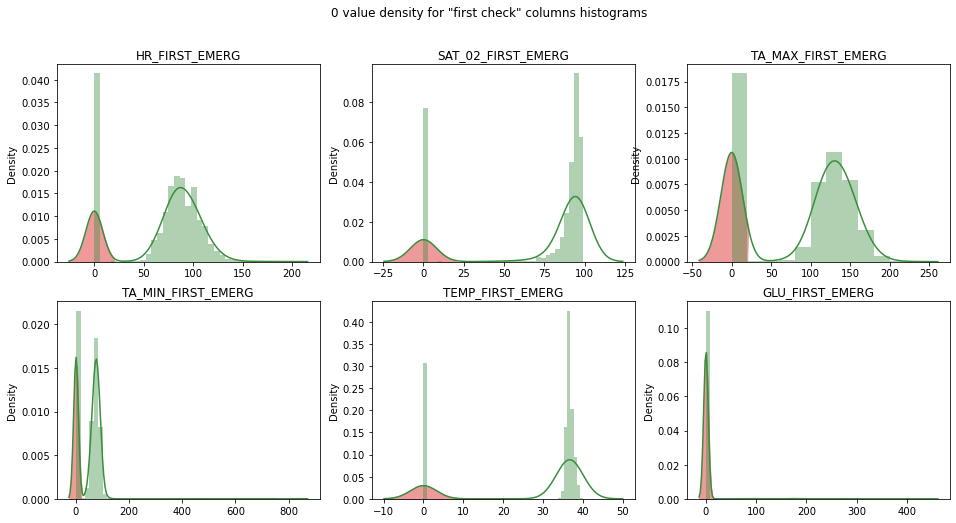

In [214]:
columns_first_check = ['HR_FIRST_EMERG', 'SAT_02_FIRST_EMERG', 'TA_MAX_FIRST_EMERG', 'TA_MIN_FIRST_EMERG',
                       'TEMP_FIRST_EMERG', 'GLU_FIRST_EMERG']
custom_plot(df_patient, columns_first_check, 2, 3, '0 value density for "first check" columns histograms')

In [215]:
df_patient[columns_first_check].describe()

,HR_FIRST_EMERG,SAT_02_FIRST_EMERG,TA_MAX_FIRST_EMERG,TA_MIN_FIRST_EMERG,TEMP_FIRST_EMERG,GLU_FIRST_EMERG
count,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000
mean,68.368669,71.680016,83.611700,48.192776,27.646761,2.101296
std,41.047933,39.150174,65.888122,43.013281,15.850918,21.831461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,76.000000,0.000000,0.000000,35.000000,0.000000
50%,82.000000,93.000000,115.000000,64.000000,36.300000,0.000000
75%,97.000000,96.000000,138.000000,79.000000,36.900000,0.000000
max,190.000000,99.000000,220.000000,845.000000,40.100000,448.000000


In [216]:
sum(df_patient['TA_MIN_FIRST_EMERG']>200)

2

Full of outliers and 0 values.

Outlier removal.

In [128]:
z_scores = stats.zscore(df_patient[columns_first_check])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_patient = df_patient[filtered_entries]